# Projeto B - Previsão de Faturamento

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

blah blah blah inicial

In [1]:
# importação de bibliotecas

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados e análise inicial

Inicialmente, vamos importar e ver a aparência geral dos dados:

* número e nome de colunas
* qual o tipo de dados de cada coluna
* Algumas linhas do dataset

In [2]:
# importar base e iniciar a análise inicial
ts_raw = pd.read_csv(r'sim_ts.txt', sep = '\t')
ts_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   vlr      511 non-null    float64
 1   date     511 non-null    object 
 2   produto  511 non-null    object 
dtypes: float64(1), object(2)
memory usage: 12.1+ KB


In [3]:
ts_raw.describe()

,vlr
count,5.110000e+02
mean,4.187929e+08
std,6.272376e+08
min,0.000000e+00
25%,6.472878e+05
50%,2.261791e+07
75%,1.028848e+09
max,1.990000e+09


In [4]:
ts_raw.sample(5).sort_index()

,vlr,date,produto
11,1.037052e+09,2010-11-01,alimenticio
27,1.064472e+09,2012-03-01,alimenticio
48,1.214930e+09,2013-12-01,alimenticio
171,1.633310e+08,2017-05-01,transporte
331,2.003365e+06,2018-10-01,auxilio_final_de_ano


### Limpeza dos dados

Vamos definir algumas funções de limpeza dos dados.

In [5]:
# limpeza 1: conversão de tipos

def conversao_tipos(df):
    df = df.copy()

    df['date'] = df['date'].astype('datetime64[ns]')
    df['produto'] = df['produto'].astype('category')
    return df

# limpeza 2: setar a coluna de data como indice
def setar_indice_data(df):
    df = df.copy()

    df = df.set_index('date')

    return df

# executar limpeza
ts = (ts_raw
    .pipe(conversao_tipos)
    .pipe(setar_indice_data)
)

# confirmação do dataframe limpo
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 511 entries, 2009-12-01 to 2021-10-01
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   vlr      511 non-null    float64 
 1   produto  511 non-null    category
dtypes: category(1), float64(1)
memory usage: 8.7 KB


In [6]:
ts.sample(10).sort_index()

,vlr,produto
date,,
2011-06-01,5.009648e+05,auxilio_final_de_ano
2012-08-01,7.083387e+05,auxilio_final_de_ano
2015-01-01,1.359434e+06,auxilio_final_de_ano
2015-10-01,1.463157e+05,bonificacao
2018-02-01,1.883889e+07,saude
2018-03-01,1.462332e+05,bonificacao
2018-11-01,1.667934e+09,alimenticio
2020-02-01,1.793022e+09,alimenticio
2021-04-01,1.796305e+05,bonificacao


### Análise exploratória dos dados

Primeiramente vamos fazer uma análise gráfica:

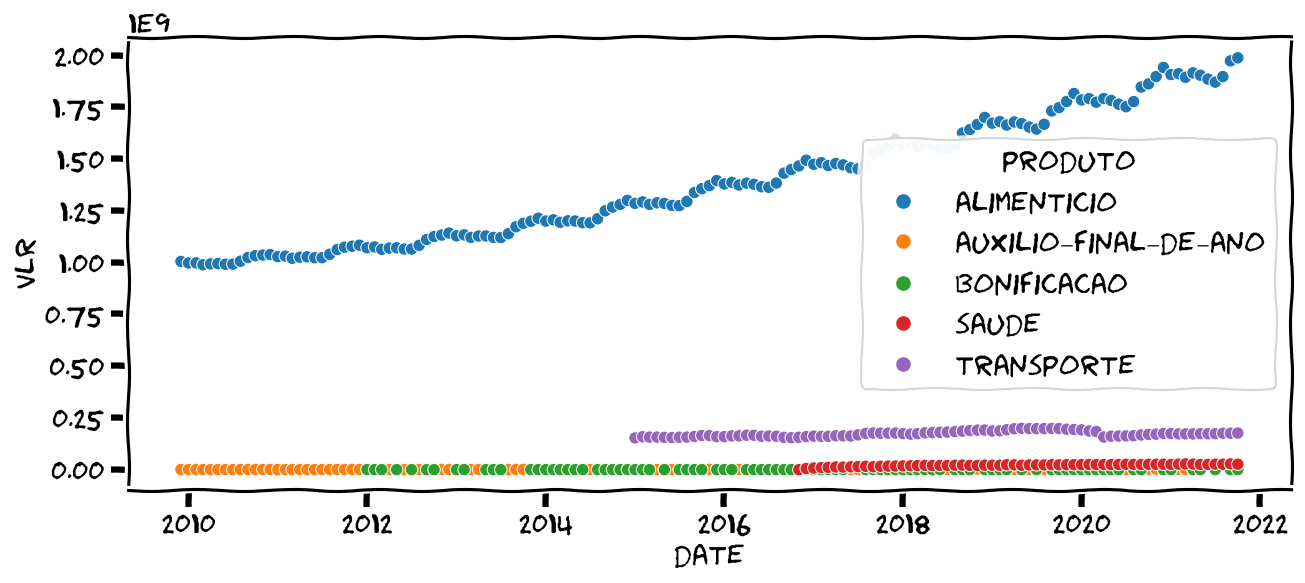

In [7]:
with plt.xkcd():
    fig = plt.figure()
    sns.scatterplot(data = ts, x = ts.index, y = 'vlr', hue = 'produto')

Claramente os valores auferidos em cada produto tem ordens de grandeza totalmente diferentes. Por conta disso, não conseguimos enxergar as tendências dos produtos com valores que tem ordens de grandeza menores.

Melhor fazer um gráfico para cada produto, com escalas diferentes para os valores.

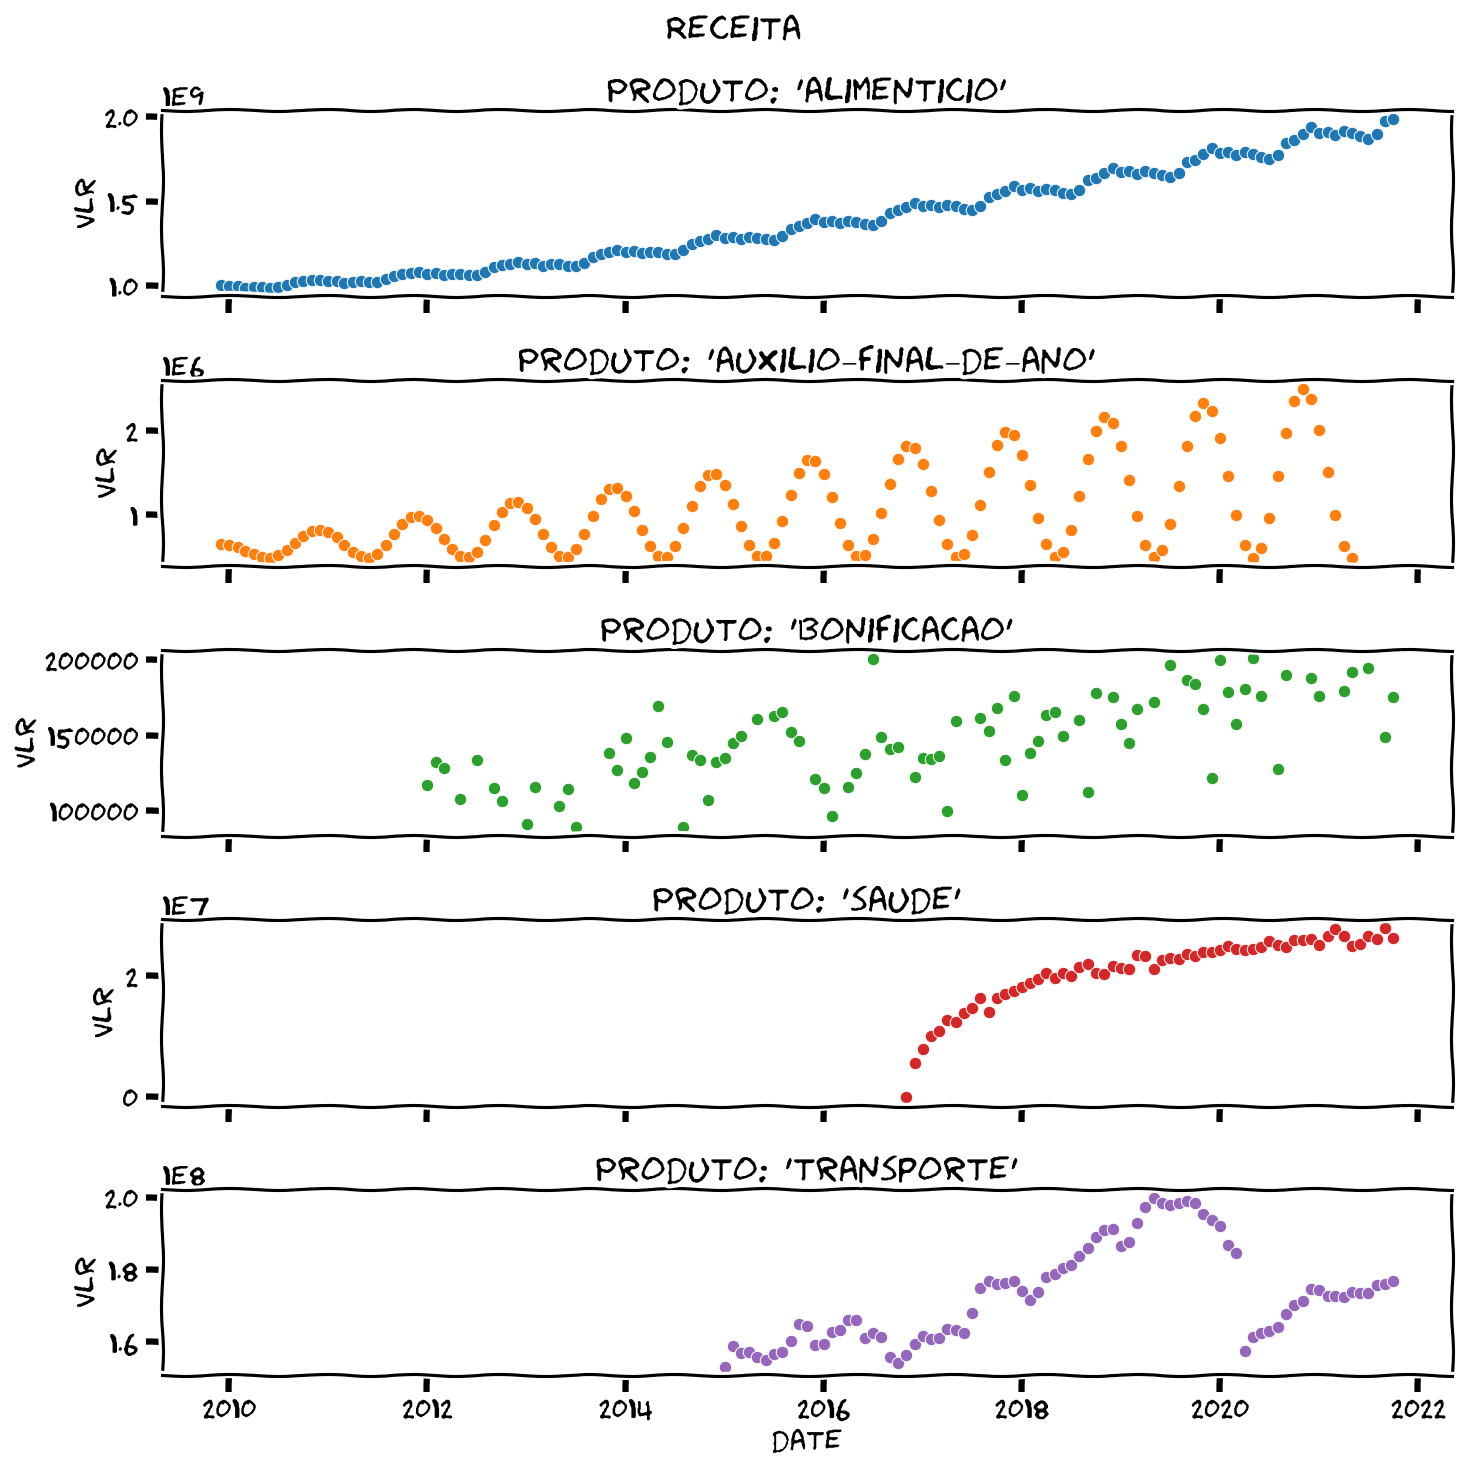

In [8]:
with plt.xkcd():

    produtos = ts['produto'].cat.categories
    n_produtos = len(produtos)

    palette = sns.color_palette(None, n_produtos)
    
    fig, axs = plt.subplots(nrows = n_produtos, ncols = 1, sharex = True, figsize = (10, 10))
    
    for i, produto in enumerate(produtos):
        ax = axs[i]
        sns.scatterplot(data = ts.loc[ts['produto'] == produto, 'vlr'], ax = ax, color = palette[i])
        ax.set_title(f"Produto: '{produto}'")
    
    fig.suptitle('Receita')
    plt.tight_layout()
    plt.show()


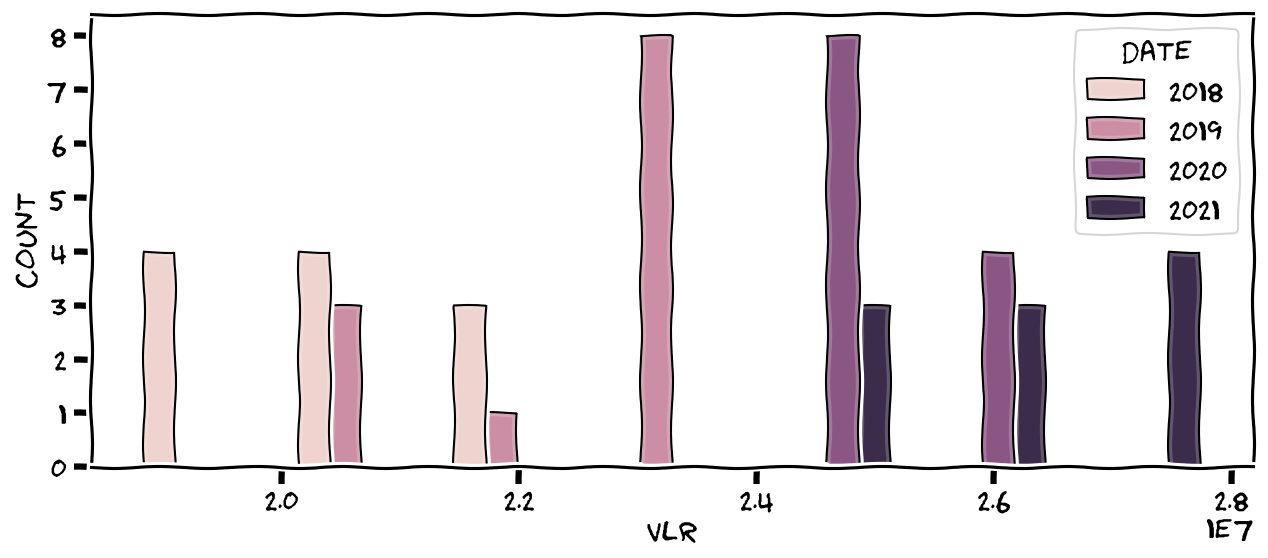

In [9]:
df = ts.loc[(ts.produto == 'saude') & (ts.index > '2018-01-01')]
hue = df.index.year

with plt.xkcd():
    sns.histplot(data = df, x = 'vlr', hue = hue, shrink = .8, multiple = 'dodge', common_norm = False)

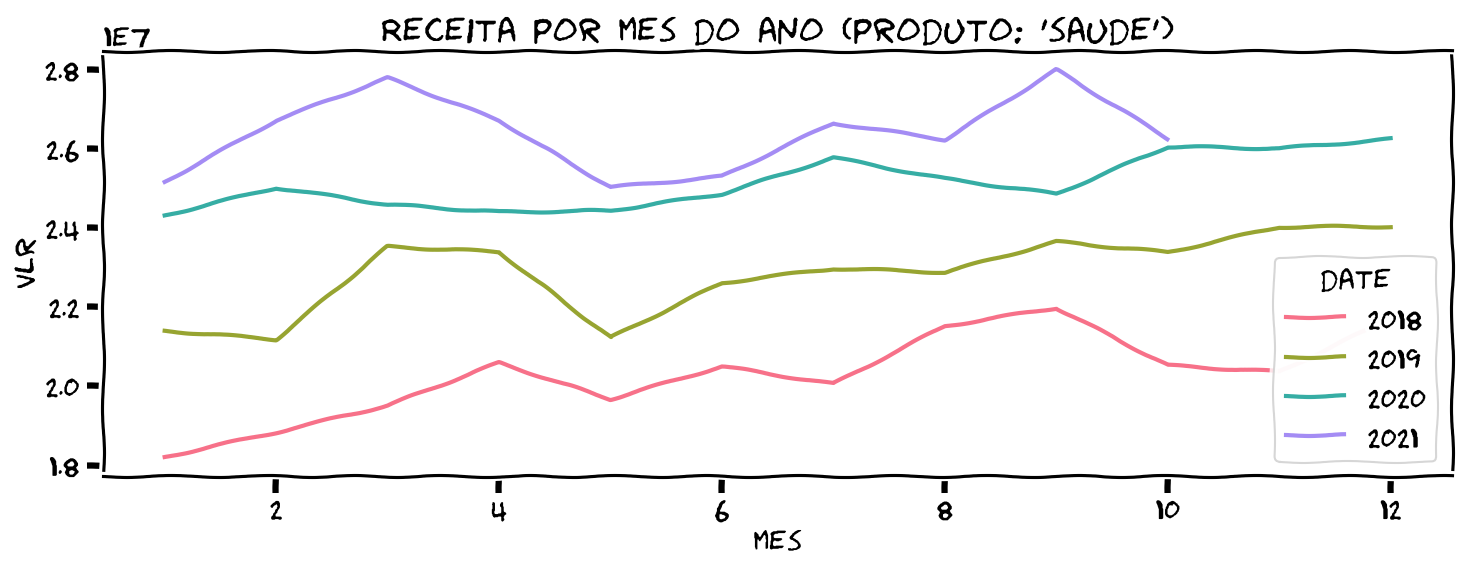

In [10]:
produto = 'saude'
df = ts[(ts.produto == produto) & ((ts.index >= '2018-01-01') | (ts.index >= '2021-12-01'))]
hue = df.index.year
x = df.index.month

with plt.xkcd():
    ax = sns.lineplot(data = df, y = 'vlr', x = x, hue = hue, palette = sns.color_palette('husl', hue.unique().shape[0]))
    ax.set_xlabel('mes')
    ax.set_title(f"Receita por mes do ano (produto: '{produto}')")
    plt.tight_layout()
    plt.show()

## Decomposição em séries de Fourier

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
decomps = {}

for produto in ts.produto.cat.categories:
    ts_filtro_naoperiodico = ts.loc[ts.produto == produto, 'vlr']
    
    # construindo um indice periodico com o qual o statsmodel consegue trabalhar
    idx_periodico = pd.date_range(
        start = ts_filtro_naoperiodico.index.min(), 
        end = ts_filtro_naoperiodico.index.max(),
        freq = 'MS'
    )
    ts_filtro = ts_filtro_naoperiodico.reindex(idx_periodico)

    # como preenchemos os nans?
    ts_filtro.fillna(0, inplace = True)

    decomps[produto] = seasonal_decompose(ts_filtro)

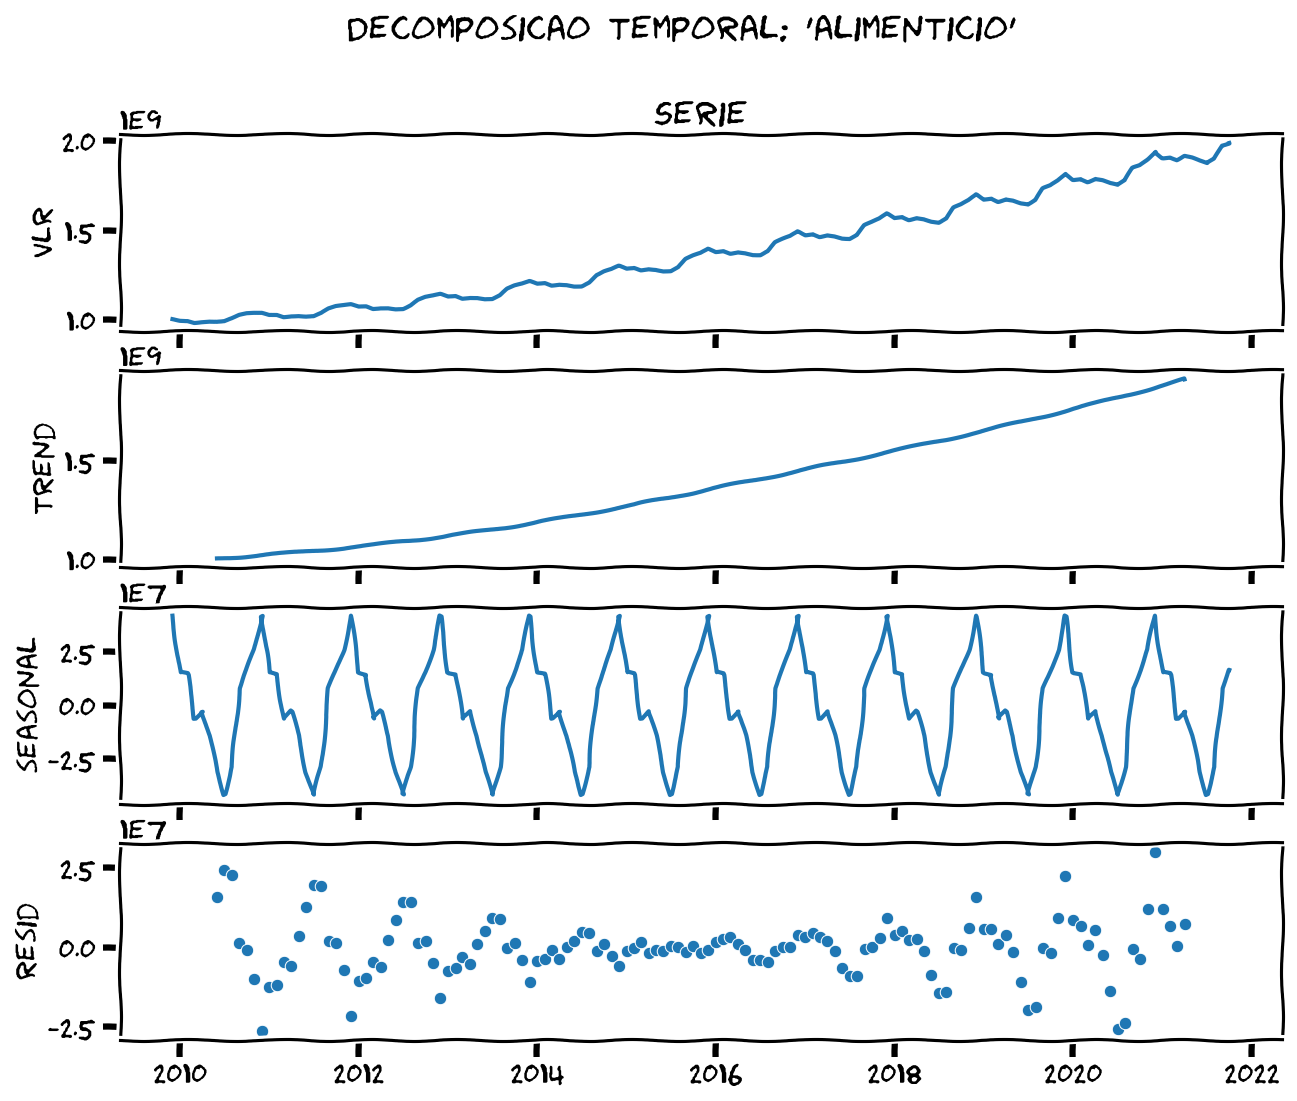

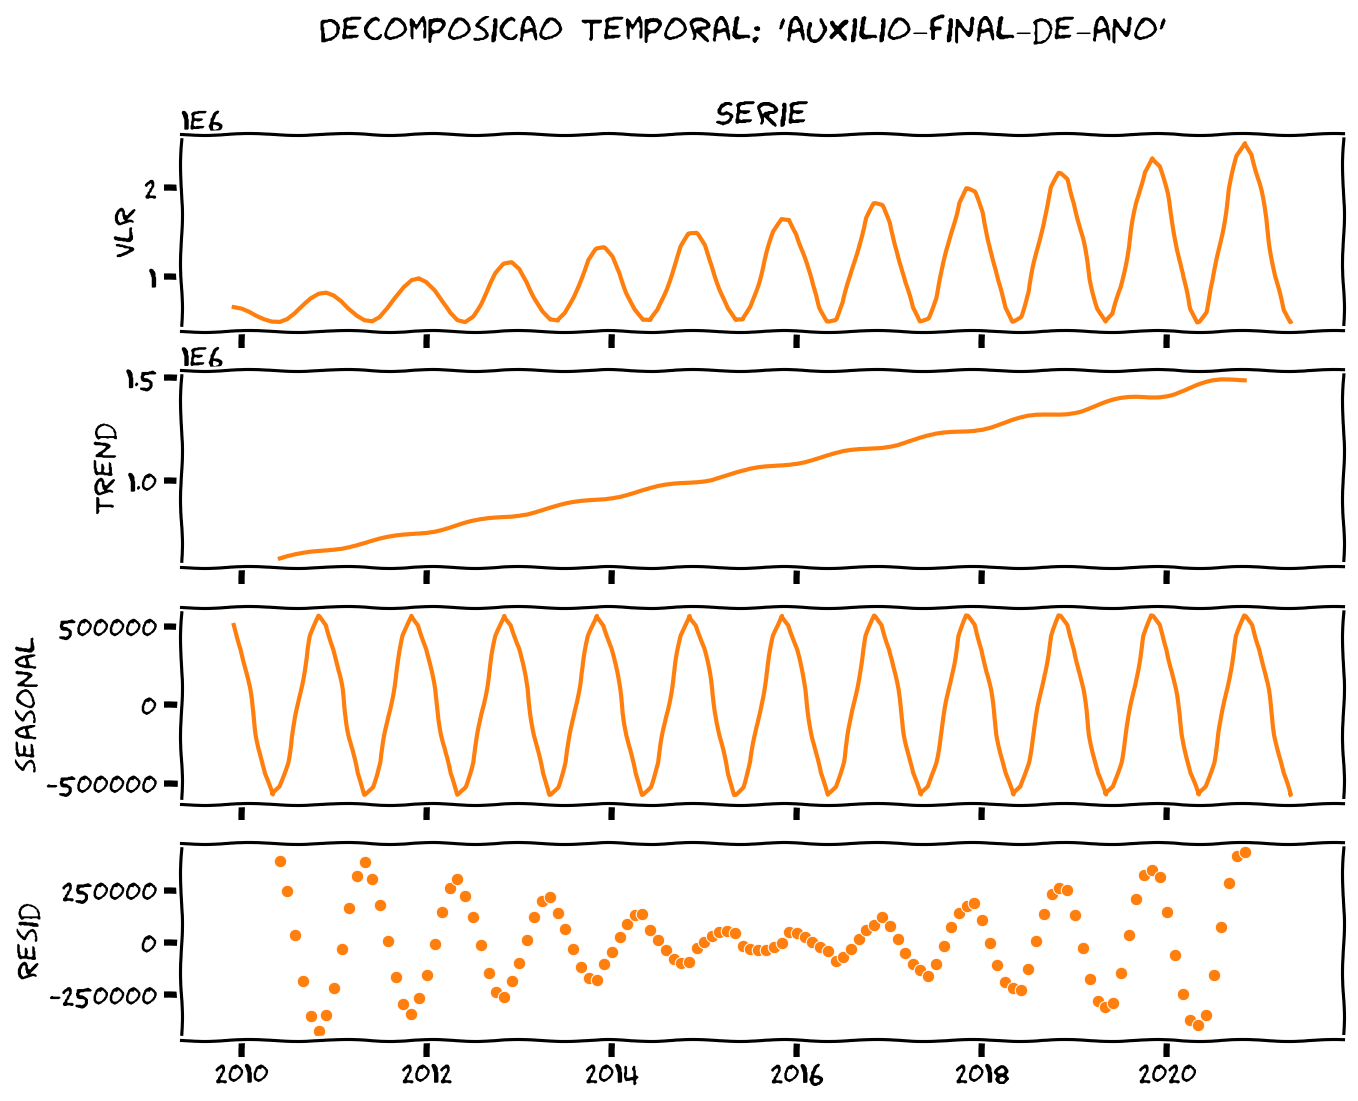

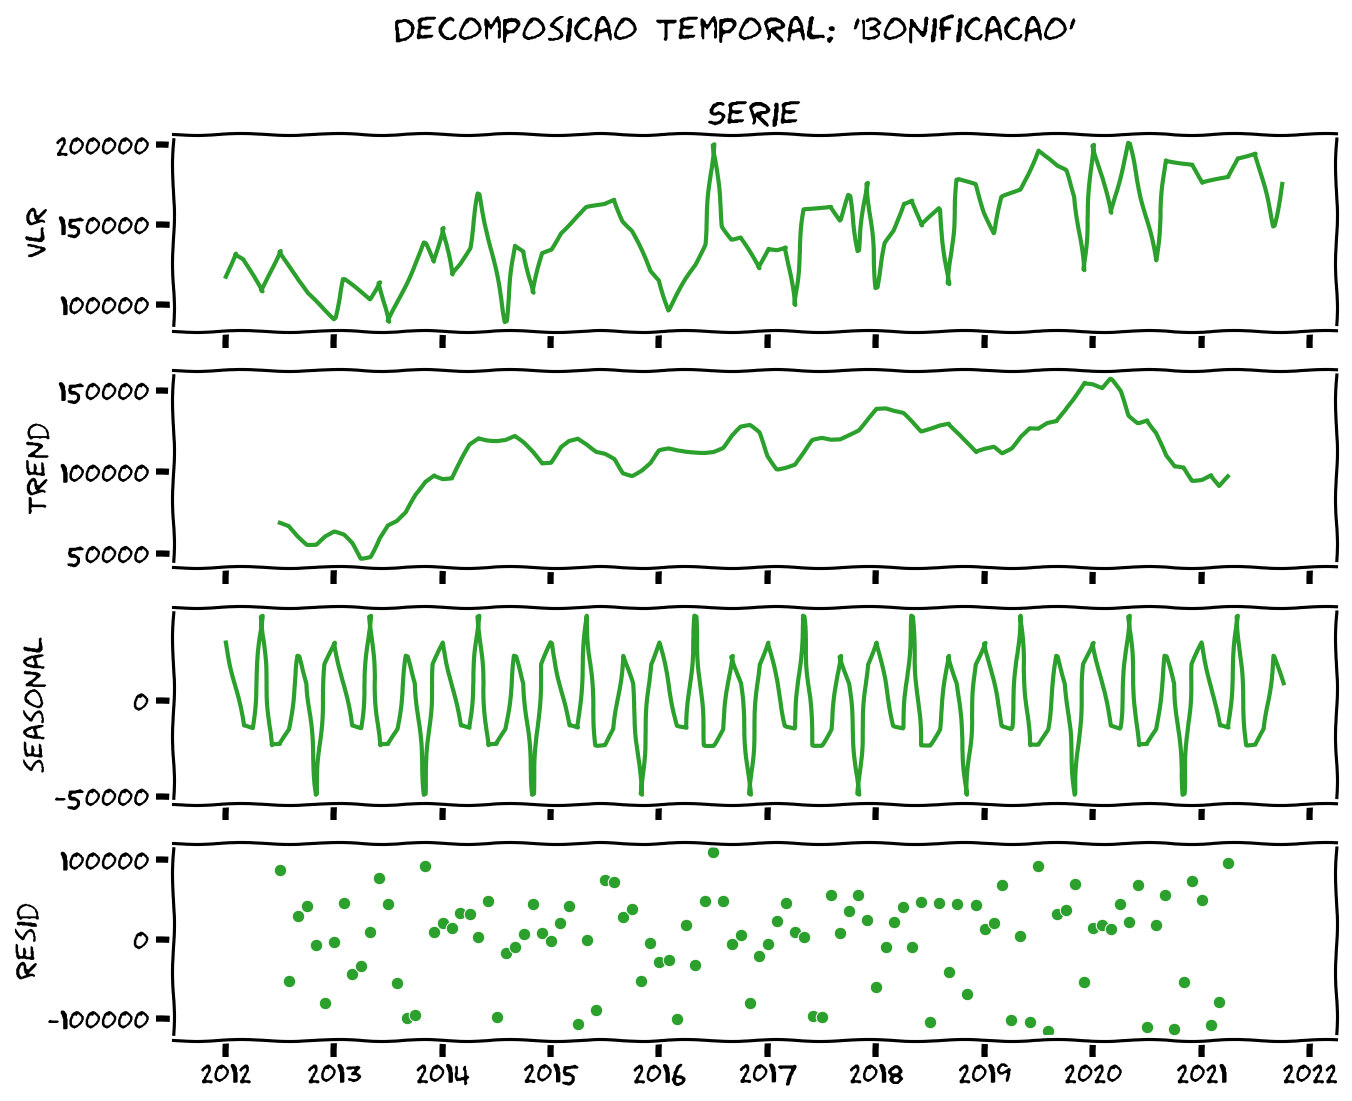

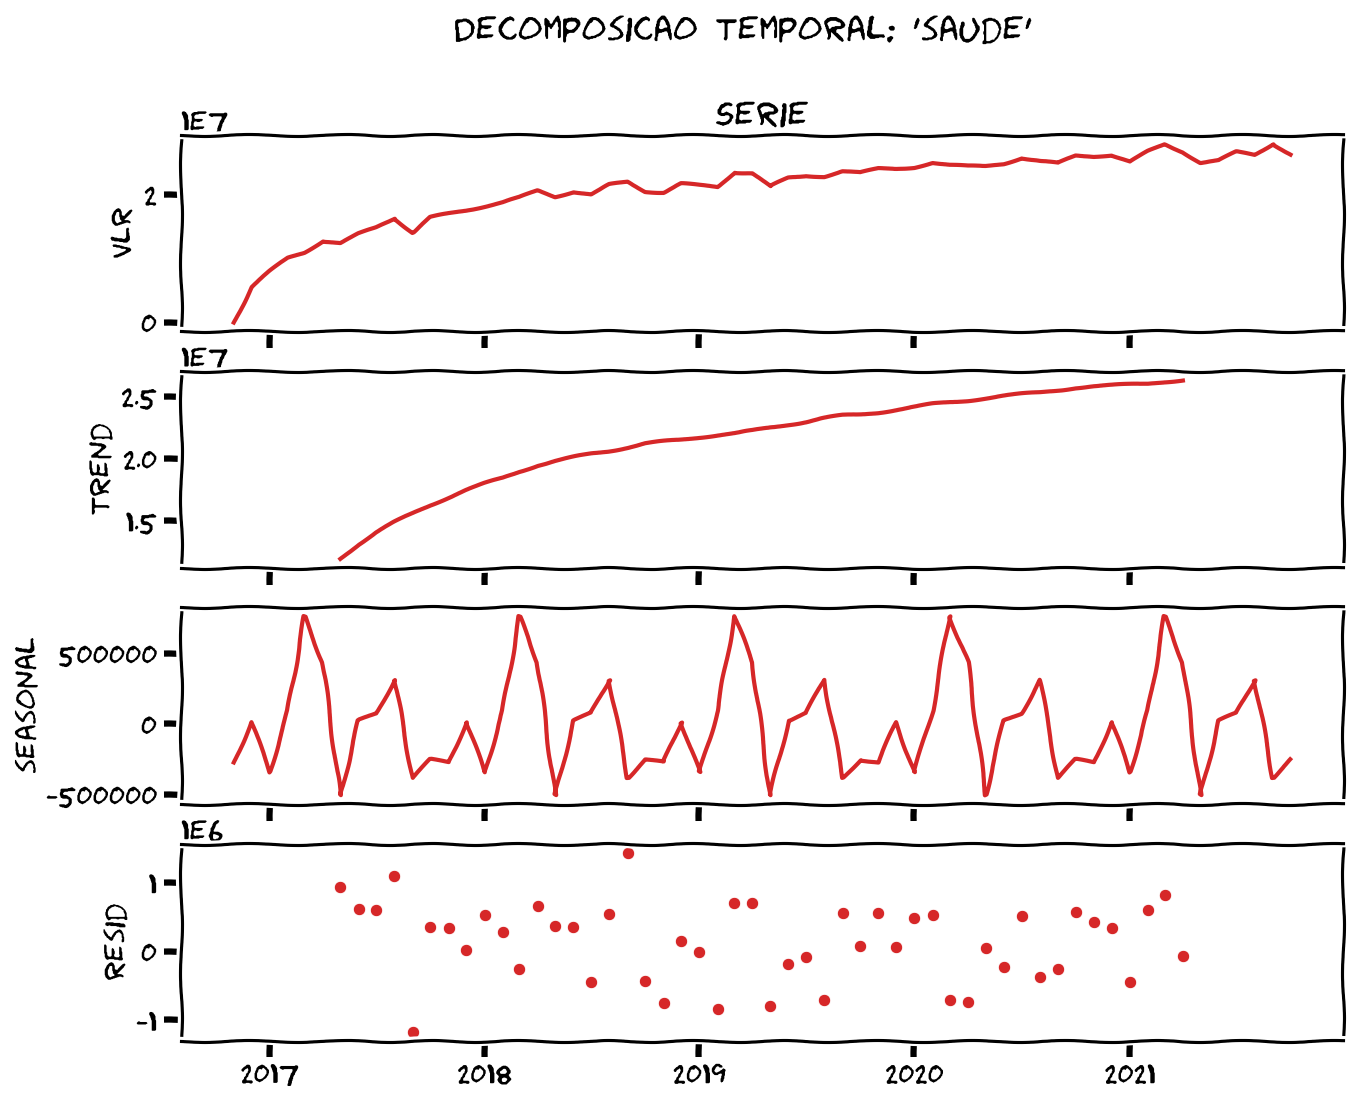

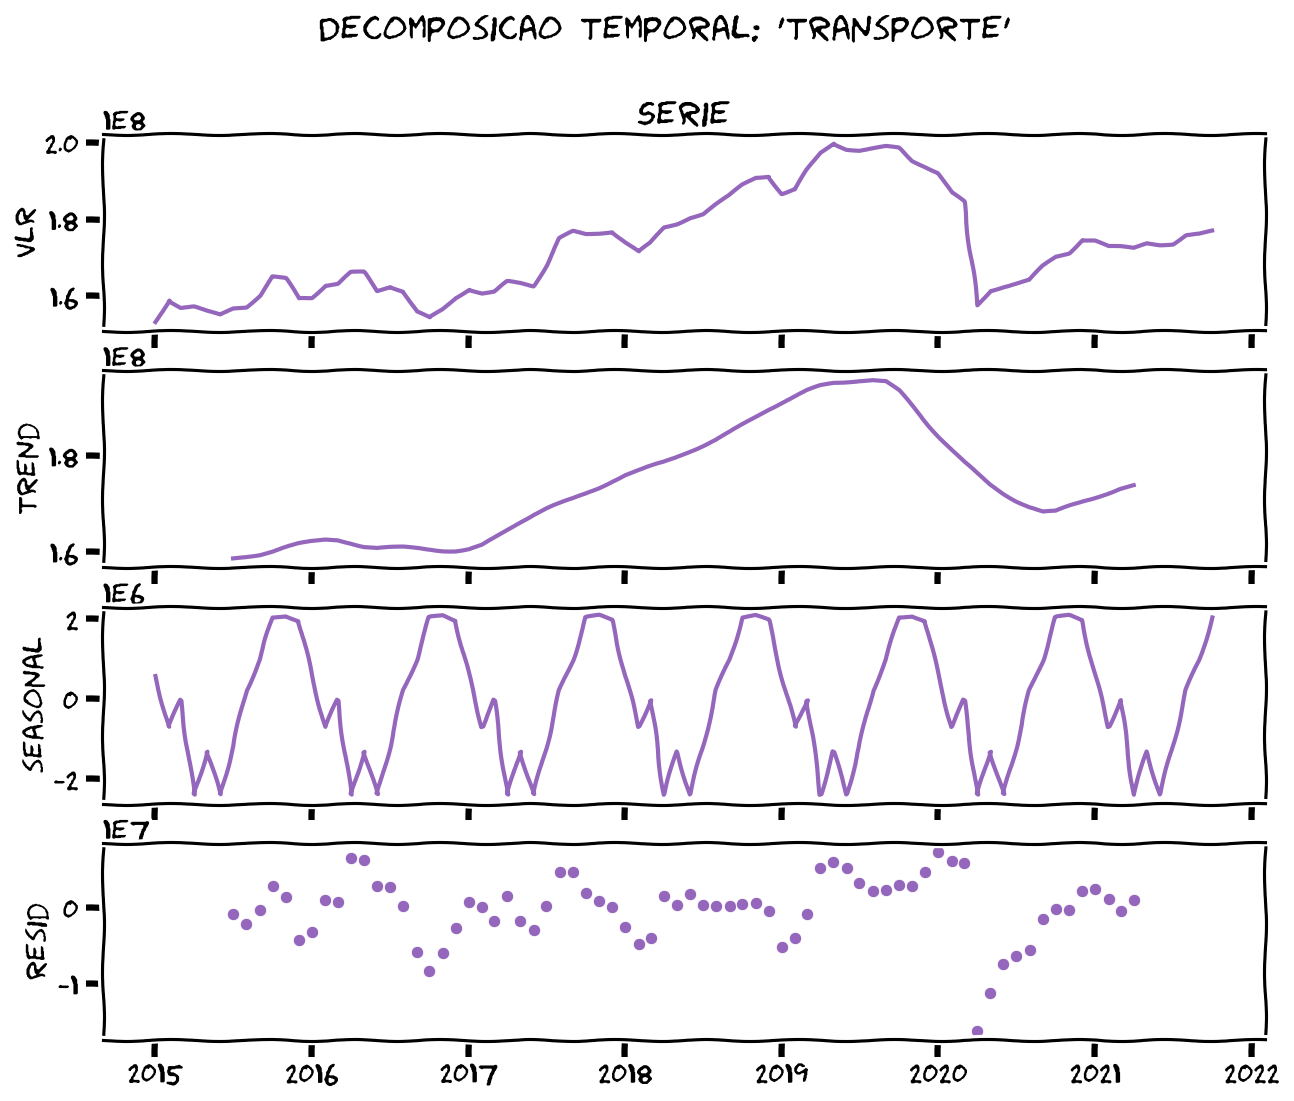

In [39]:
with plt.xkcd():
    n_produtos = len(decomps.keys())
    palette = sns.color_palette(None, n_produtos)

    for i, (produto, decomp) in enumerate(decomps.items()):
        fig, axs = plt.subplots(nrows = 4, figsize = (10, 8), sharex = True)
        ts_filtro = ts.loc[ts.produto == produto, 'vlr']

        c = palette[i]
        
        sns.lineplot(data = ts_filtro, ax = axs[0], color = c)
        axs[0].set_title('Serie')

        sns.lineplot(data = decomp.trend, ax = axs[1], color = c)

        sns.lineplot(data = decomp.seasonal, ax = axs[2], color = c)

        sns.scatterplot(data = decomp.resid, ax = axs[3], color = c)
        
        fig.suptitle(f"Decomposicao temporal: '{produto}'")
        plt.show()

In [45]:
produto


'transporte'

In [46]:
ts_filtro = ts.loc[ts.produto == produto, 'vlr']

In [47]:
ts_filtro

date
2015-01-01    1.532707e+08
2015-02-01    1.590025e+08
2015-03-01    1.570495e+08
2015-04-01    1.572236e+08
2015-05-01    1.559886e+08
                  ...     
2021-06-01    1.735395e+08
2021-07-01    1.737046e+08
2021-08-01    1.759447e+08
2021-09-01    1.761901e+08
2021-10-01    1.768986e+08
Name: vlr, Length: 82, dtype: float64